Scrape Data from Craiglist Housing with Selenium and BeautifulSoup

URL:
https://vancouver.craigslist.org/search/apa?hasPic=1&srchType=T#search=1~list~0~0
https://toronto.craigslist.org/search/apa?availabilityMode=1&hasPic=1&srchType=T#search=1~list~0~0

In [59]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

from datetime import datetime
import math
import re


In [60]:
#Helper Function
def substring_after(s, delim):
    return s.partition(delim)[2]

In [61]:
class CraiglistScraper(object):
    def __init__(self, url):
        self.url = url
        self.driver = webdriver.Firefox()
        self.driver.get(self.url)
        self.delay = 3

    def test(self):
        print(self.url)

    def print_total(self): 
        # Help getting the total number of available postings 
        str = self.driver.find_element(By.CLASS_NAME,"cl-page-number").text
        total_pages = int( substring_after(str, " of").replace(' ','').replace(',',''))
        return total_pages

    def load_craiglist_url(self):
        self.driver.get(self.url)
        try:
            wait = WebDriverWait(self.driver, self.delay)
            wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "cl-search-result")))
            print("Page is ready")
        except TimeoutException:
            print("Time out!")

    def extract_post_info(self):
        dates, titles, cities, bdrs, sqfts, prices = ( [] for i in range(6))
        all_posts = self.driver.find_elements(By.CLASS_NAME,"cl-search-result") 
        for post in all_posts:
            #print(post.text)
            content = post.text.split("·")
            if len(content) == 5:
                title = content[0]
                address = content[1]
                date_str = content[2]
                if re.search("[0-9]+/[0-9]+",date_str):
                    date_str = date_str.split("/")
                    month = int(date_str[0])
                    day = int(date_str[1])
                    currentYear = datetime.now().year
                    date = datetime.date(datetime(currentYear, month, day))
                else:
                    date = datetime.date(datetime.now())
                
                area = content[3].strip().split("br")

                if len(area) == 2:
                    bdr = float(area[0])
                    sqft = float(area[1].strip().replace('ft2','')) if len(area[1]) != 0 else None
                else:
                    if area[0].find("ft")>0:
                        sqft = float(area[0].strip().replace('ft2',''))
                        bdr= None
                    else:
                        bdr = area[0]
                        sqft = None
                
                #edge case: Studio
                if (bdr == None and str(title).lower().find('studio') >=0) or (bdr == None and str(title).lower().find('bachelor') >=0):
                    bdr = 1

                price = re.findall(r'\$\d+(?:\,\d+)?', content[4])[0]
                price = float(str(price).strip().replace('$','').replace(',','')) 

                titles.append(title)
                cities.append(address)
                dates.append(date)
                bdrs.append(bdr)
                sqfts.append(sqft)
                prices.append(price)
            
            elif len(content) == 4:
                title = content[0]
                address = content[1]
                date = content[2]
                bdr, sqft = None, None

                try:
                    price = re.findall(r'\$\d+(?:\,\d+)?', content[3])[0]
                    price = float(str(price).strip().replace('$','').replace(',','')) 
                except:
                    price= None

                 #edge case for Studio
                if (bdr == None and str(title).lower().find('studio') >=0) or (bdr == None and str(title).lower().find('bachelor') >=0):
                    bdr = 1

                titles.append(title)
                cities.append(address)
                dates.append(date)
                bdrs.append(bdr)
                sqfts.append(sqft)
                prices.append(price)
                
            else:
                print("WARNING_____"  )
                print(content)
                post_content = ','.join(content)
                titles.append(post_content)
                cities.append(None)
                dates.append(None)
                bdrs.append(None)
                sqfts.append(None)
                prices.append(None)

        return titles,cities,prices,dates,bdrs,sqfts

    def extract_post_url(self):
        url_list =[]
        content = self.driver.page_source.encode('utf-8').strip()
        soup = BeautifulSoup(content,"html.parser")
        for link in soup.findAll("a", {"class":"titlestring"}):
            url_list.append(link["href"])
        return url_list
    
    def quit(self):
        self.driver.close()



In [62]:
vancouver_area = ['bnc','rds','nvn','rch','pml','van']
toronto_area = ['bra','tor','drh','mss','oak','yrk']
other_areas =['victoria','winnipeg','abbotsford', 'calgary', 'edmonton', 'halifax', 'hamilton','kitchener','ottawa']

post_titles, post_area, post_address, post_price, post_dates, post_brs, post_sqft, post_urls = ([] for i in range(8))

for area in toronto_area:
    total_page = 10000
    start = 0
    while start < total_page:
        #base_url = f"https://vancouver.craigslist.org/search/{area}/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~{start}~0"
        base_url = f"https://toronto.craigslist.org/search/{area}/apa?availabilityMode=1&hasPic=1&srchType=T#search=1~list~{start}~0"
        #base_url = f"https://{area}.craigslist.org/search/apa?availabilityMode=1&hasPic=1&srchType=T#search=1~list~{start}~0"
        scraper = CraiglistScraper(base_url)
        scraper.test()
        scraper.load_craiglist_url()
        
        if total_page == 10000: 
            total_page = math.ceil(scraper.print_total()/120)
            print("Total page :")    
            print(total_page)
            
        info = scraper.extract_post_info()
        post_titles += info[0]
        post_address += info[1]
        post_price += info[2]
        post_dates += info[3]
        post_brs += info[4]
        post_sqft += info[5]
        urls = scraper.extract_post_url()
        post_urls += urls
        post_area += [area]*len(urls)
        
        start+= 1
        scraper.quit()

https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~0~0
Page is ready
Total page :
6
https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~1~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~2~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~3~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~4~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~5~0
Page is ready
https://vancouver.craigslist.org/search/rds/apa?availabilityMode=1&bundleDuplicates=1&hasPic=1&srchType=T#search=1~list~0~0
Page is ready
Total page :
7
http

In [64]:
import pandas
df = pandas.DataFrame(data ={"Title": post_titles , "Area": post_area, "Address": post_address, "Price": post_price, "Date": post_dates,
                              "Number of Bedroom": post_brs, "Square Feet": post_sqft, "URL": post_urls})
df['Area'] = df['Area'].replace(['bnc','rds','nvn','rch','pml','van'],['Burnaby/Newwest','Delta/Surrey/Langley', 'North Shore' , 'Richmond', 'Tricities/Pitt/Maple','Vancouver'])
df['Area'] = df['Area'].replace(['bra','tor','drh','mss','oak','yrk'],['Brampton', 'City of Toronto', 'Durham Region', 'Mississauga', 'Oakville', 'York Region'])

df['Area'] = df['Area'].str.capitalize()
df = df.drop_duplicates(subset= ['Title','Price','Number of Bedroom','Square Feet'])
df['Price'] = df['Price'].mask(df['Price']<100) # Convert price to Nan when its less than 100

print("Number of Postings is ", len(df))
df.to_csv("./Housing_Craiglist_Toronto.csv", sep=',',index=False)

Number of Postings is  4016


In [65]:
df.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,4007.00,3913.00,3528.00
mean,3389.78,2.03,1103.69
std,2384.64,1.07,935.30
min,100.00,1.00,1.00
25%,2300.00,1.00,640.00
50%,2850.00,2.00,850.00
75%,3685.00,2.00,1130.00
max,60000.00,8.00,16000.00


In [66]:
#Calling the .describe() method to get a more detailed look.
#The cheapest 1-bedroom place in City of Toronto is $299, and the most expensive is $6,850
#While the mean price is $2.476
one_br = df.loc[ (df['Number of Bedroom'] == 1)  ]
one_br.describe().round(2)


,Price,Number of Bedroom,Square Feet
count,1293.00,1294.0,1125.00
mean,2323.59,1.0,628.60
std,609.93,0.0,282.09
min,100.00,1.0,1.00
25%,1900.00,1.0,527.00
50%,2275.00,1.0,604.00
75%,2650.00,1.0,670.00
max,5500.00,1.0,6000.00


In [ ]:
two_br = df.loc[ (df['Number of Bedroom'] == 2) & (df['Area'] == 'City of Toronto' )]
two_br.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [ ]:
three_br = df.loc[df['Number of Bedroom'] == 3 & (df['Area'] == 'City of Toronto' )]
three_br.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


<AxesSubplot: xlabel='Number of Bedroom', ylabel='count'>

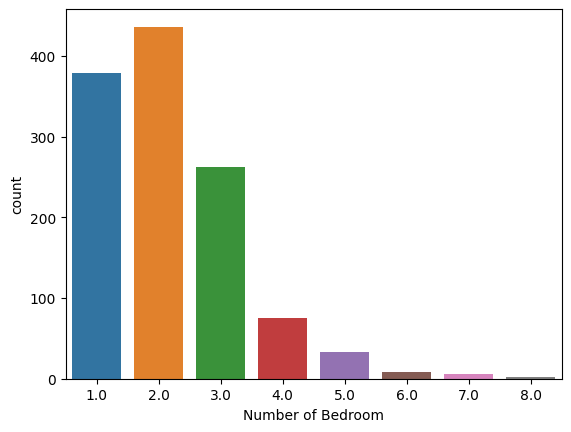

In [ ]:
import seaborn as sns
sns.countplot(x = df['Number of Bedroom'])

In [ ]:
avg_price = df.groupby(df['Number of Bedroom']).mean().round(2)
print(avg_price)

                     Price  Square Feet
Number of Bedroom                      
1.0                1705.77       633.30
2.0                2200.60       984.15
3.0                2778.90      2324.51
4.0                3541.99      2432.21
5.0                3796.33      2566.54
6.0                3837.50      2717.71
7.0                5925.00      5213.00
8.0                6500.00      2281.00


C:\Users\Tu\AppData\Local\Temp\ipykernel_7456\3924533294.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_price = df.groupby(df['Number of Bedroom']).mean().round(2)
